# Tutorial 3 - Differential Power Analysis on Xoodyak

Before beginning this tutorial, let's import some useful libraries. You may add other libraries.

In [1]:
# Import some useful libraries
from scipy.stats import pearsonr   # to compute Pearson correlation
import numpy as np                 # to handle numpy arrays
import matplotlib.pyplot as plt    # to plot graphs
from tqdm import tqdm              # to show a progress meter for loops
import random                      # to generate pseudo-random numbers

## 1 - Get to know your traces
The target of our attack is a hardware implementation of [Xoodyak](https://github.com/KeccakTeam/Xoodoo/tree/master/Hardware/FPGA/AEAD/Xoodyak_R3) running on the Sakura-G FPGA board, a development board specifically designed for SCA.

Download the Xoodyak power traces from Brightspace. The collected traces correspond to the Xoodoo permutation during the initialization phase. In the target implementation, a 384-bit register, representing the Xoodoo state, is updated at every clock cycle with the output of the round logic.

Load the dataset in the cell below. Use ```.files``` to investigate which arrays are present.


In [6]:
tutorial3_arrays = open("tutorial3_arrays.npz", "rb")
measurements = np.load(tutorial3_arrays)
print(measurements.files)

['traces', 'nonces', 'key']


### 1.1 - Check dimensions

Before starting implementing an attack, it is a good practice to first have a look at the collected data to make sure (or at least be confident) that the aquisition was succesfull. For each of the arrays, print the shape and answer the questions in the pdf.

In [18]:
# Investigate the dimensions
print(measurements["traces"].shape)
print(measurements["nonces"].shape)
print(measurements["key"])

(20000, 5000)
(20000, 16)
[ 16  59 131  78 155 207 234  33  43  20 176 222 229  52 245 214]


### 1.2 - Visual examination of traces

Plot the average power trace. How many rounds of Xoodoo can you count?

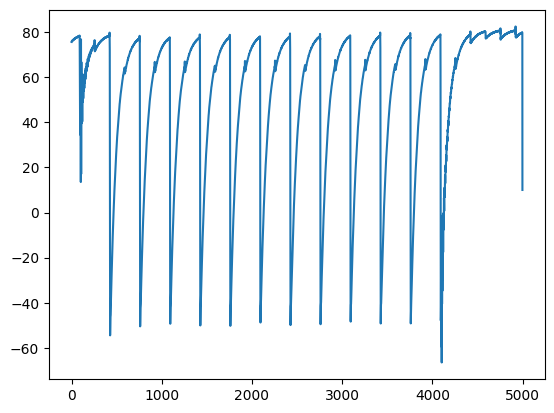

In [10]:
# Plot average power trace

traces = measurements["traces"]

plt.plot(traces.mean(axis=0))

### 1.3 - Cut the traces
In this tutorial, we will attack the first round of Xoodoo. By using visual inspection, truncate the traces to only encompass the first round. Define the start and end sample below.

In [12]:
start_sample = 200 # Fill here
end_sample = 800 # Fill here

nr_samples = end_sample - start_sample

traces_truncated = traces[:,start_sample:end_sample]# Fill here


Now, plot the average truncated trace.

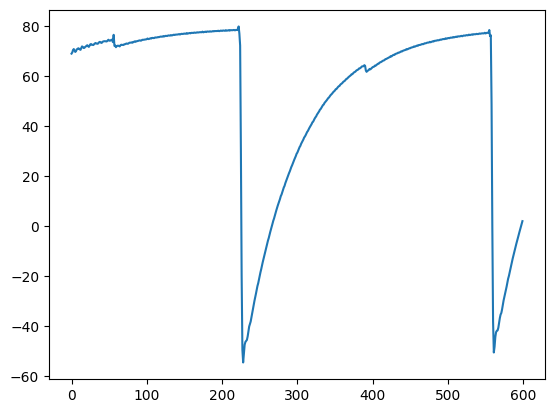

In [13]:
# Plot the average truncated trace
plt.plot(traces_truncated.mean(axis=0))

## 2 - Getting to know Xoodoo - defining some auxiliary functions

Xoodyak is a lightweight authentication encryption scheme with associated data. It consists of 12 rounds, where each round is considered the Xoodoo-permutation. 

The Xoodoo round function consists of 5 parts: linear mixing, plane shifts, round addition, S-box and another plane shift. The sensitive intermediate variable for our side-channel attack will again be the s-box.

The Xoodoo state consists of 384 bits arranged grouped in words of 12 in a three dimensional state. We can represent it in different ways in Python. In this tutorial, you will work with an array with three rows and four columns, where each element of the array is a 32-bit integer representing a 32-bit lane (3 * 4 * 32 = 384 bits)

Run the cell block below to initialise the representation of the Xoodoo state.

In [19]:
xoodoo_state = np.zeros((3,4), dtype='uint32')
print(xoodoo_state)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


Keep in mind that 2D-indexing in Python usually is defined as array[rows, columns]. However, for the Xoodoo-state, we represent the y-axis as the rows in Python, and the x-axis as the columns in Python. The z-axis is defined by a 32-bit unsigned integer. Complete the code snippet below.

In [20]:
# Set some lanes using (x, y) -> mapped to (y, z) to match Xoodoo's coordinate system
xoodoo_state[2,1] = 3  # y=2, z=1

# Show full state
print("Full Xoodoo state:\n", xoodoo_state)

# Print a plane at y=2 
y = 2
print(f"Xoodoo plane at y = {y}:", xoodoo_state[y, :])  

# Print lane at (x, y) = (1, 2)
x, y = 1, 2
print(f"Xoodoo lane at (x,y) = ({x},{y}):", xoodoo_state[y, x])

# Extract a specific bit at location (x, y, z)
bit_nr = 0 # any value between 0 - 31
x, y, z = 1, 2, bit_nr
bit_val = (xoodoo_state[y, x] >> z) & 1
print(f"Xoodoo bit {bit_nr} at (x,y,z)=({x},{y},{z}):", bit_val)


Full Xoodoo state:
 [[0 0 0 0]
 [0 0 0 0]
 [0 3 0 0]]
Xoodoo plane at y = 2: [0 3 0 0]
Xoodoo lane at (x,y) = (1,2): 3
Xoodoo bit 0 at (x,y,z)=(1,2,0): 1


Below we provide an auxiliary function to print the state in hex values. This is convenient later for debugging purposes.

In [21]:
def print_state(xoodoo_state):
    for i in range(3):
        print([hex(xoodoo_state[i,j]) for j in range(4)]) 
        
print_state(xoodoo_state)

['0x0', '0x0', '0x0', '0x0']
['0x0', '0x0', '0x0', '0x0']
['0x0', '0x3', '0x0', '0x0']


### 2.1 - Extract bits from the state

We will use a divide-and-conquer approach, where we will recover one column of the state at the time. Let's make some auxiliary functions to access a specific column easily. You can have a look at the example earlier. 

In [31]:
# extract the bit given a state and a set of coordinates (x,y,z)
def get_bit(state,x,y,z):
    lane = state[y, x] # Fill here
    return (lane >> z) & 1

# extract the column given a state and a set of coordinates (x,z)
def get_column(state,x,z):
    return tuple((col >> z) & 1 for col in state[:, x])
    #return tuple((state[i, x] >> z) & 1 for i in range(3))

Use the code below to test your code.

In [32]:
# set some bits and try to recover them
xoodoo_state = np.zeros((3,4), dtype='uint32')
xoodoo_state[0,0] = 9
xoodoo_state[1,0] = 7
print_state(xoodoo_state)
print(get_bit(xoodoo_state,0,0,0)==1)
print(get_column(xoodoo_state,0,0)==(1,1,0))

['0x9', '0x0', '0x0', '0x0']
['0x7', '0x0', '0x0', '0x0']
['0x0', '0x0', '0x0', '0x0']
True
True


### 2.2 - Load in Xoodoo state

Unlike our previous attacks on software AES, we cannot directly attack the output of the s-box operation, as the road between state $A$ to state $A\prime$ is done using circuits. We can only obtain leakage from $A$ and $A\prime$ being stored in  registers. Thus, we need to keep track of the internal states of Xoodoo.

First, let's start with a toy example to get to know Xoodoo better. Load in the ```toy_key``` and the ```toy_nonce``` into the Xoodoo state. Note that the Xoodoo state operates in words of 4 bytes each. In which plane is the key stored? And which plane the nonce?

In [54]:
toy_key = [2, 4, 6, 8, 10, 12, 14 ,16, 18, 20, 22, 24, 26, 28, 30, 32] 
toy_nonce = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48]

# Fill the Xoodoo-state with the key and nonce
def bytes_to_word(bs):
    
    w = 0
    for b in bs[::-1]:
        w = (w << 8) | b
    return w

xoodoo_state = np.zeros((3,4), dtype='uint32')

def fill_xodoo(xoodoo_state, key, nonce):
    for i in range(0, 4):
        xoodoo_state[0, i] = bytes_to_word(key[i*4:(i+1)*4])
        xoodoo_state[1, i] = bytes_to_word(nonce[i*4:(i+1)*4])

fill_xodoo(xoodoo_state, toy_key, toy_nonce)


# Add padding / domain separation bits (do not change)
xoodoo_state[2,0] = 0x0110
xoodoo_state[2,3] = 0x02000000

print_state(xoodoo_state)

['0x8060402', '0x100e0c0a', '0x18161412', '0x201e1c1a']
['0xc090603', '0x1815120f', '0x24211e1b', '0x302d2a27']
['0x110', '0x0', '0x0', '0x2000000']


### 2.3 - Define Xoodoo step functions

Below, you find auxiliary functions from all the Xoodoo steps. Run the cells to load in the functions. 

In [44]:
def theta(state_in):
    # initialize the output to the zero state
    state_out = np.zeros((3,4), dtype='uint32')
    
    # initialize the parity planes at 0
    P = [0, 0, 0, 0]
    P_1_5 = [0, 0, 0, 0]
    P_1_14 = [0, 0, 0, 0]
    E = [0, 0, 0, 0]
    
    # compute the parity plane 
    P = state_in[0] ^ state_in[1] ^ state_in[2]
    
    # compute the shifted version of the parity plane and plane E
    for i in range(4):
        r = P[i]
        P_1_5[i] = (r >> 18) | (r << 14) & 0xFFFF_FFFF
        P_1_14[i] = (r >> 27) | (r << 5) & 0xFFFF_FFFF
        E[(i+1)%4] = P_1_5[i] ^ P_1_14[i]
    
    # compute the theta-effect
    for i in range(4):
        state_out[0][i] = state_in[0][i] ^ E[i]
        state_out[1][i] = state_in[1][i] ^ E[i]
        state_out[2][i] = state_in[2][i] ^ E[i]
        
    return state_out

def rho_west(state_in):
    # initialize the output to the zero state
    state_out = np.zeros((3,4), dtype='uint32')
    
    #plane 0
    state_out[0] = state_in[0]
    
    #plane 1
    state_out[1][0], state_out[1][1], state_out[1][2], state_out[1][3] = state_in[1][3], state_in[1][0], state_in[1][1], state_in[1][2]
    
    # plane 2
    for i in range(4):
        state_out[2][i] = (state_in[2][i] >> 21) | (state_in[2][i] << 11) & 0xFFFF_FFFF
    
    return state_out

def iota(state_in):
    state_out = state_in
    state_out[0][0] ^= 0x00000058
    return state_out

def chi(state_in):
    state_out = state_in
    for x in range(4):  # for each column
        a = state_out[0, x]
        b = state_out[1, x]
        c = state_out[2, x]
        state_out[0, x] = a^((b^1)&c)
        state_out[1, x] = b^((c^1)&a)
        state_out[2, x] = c^((a^1)&b)
    return state_out

def rho_east(state_in):
    state_out = np.zeros_like(state_in)
    
    # Plane y = 0: no rotation
    state_out[0] = state_in[0]
    
    # Plane y = 1: rotate each lane left by 1
    for x in range(4):
        r = state_in[1, x]
        state_out[1, x] = ((r << 1) | (r >> (32 - 1))) & 0xFFFFFFFF
    
    # Plane y = 2: rotate each lane left by 8 and shift column by 2
    for x in range(4):
        r = state_in[2, x]
        new_x = (x + 2) % 4
        state_out[2, new_x] = ((r << 8) | (r >> (32 - 8))) & 0xFFFFFFFF
    
    return state_out



With the help of the provided functions and the Xoodoo-state you have loaded in, print:
- The Xoodoo state after absorbing the key and nonce with domain seperation bits
- The Xoodoo state after iota (our sensitive variable - 3-bit sbox)
- The Xoodoo state after the first complete round

In [51]:
print("Xoodoo state after absorbing key and nonce with domain separation bits:")
print_state(xoodoo_state)

print("\nXoodoo state after iota:")
xoodoo_state_lambda = iota(rho_west(theta(xoodoo_state))) # Fill here
print_state(xoodoo_state_lambda)

print("\nXoodoo state after first complete round:")
xoodoo_after_first_round =  rho_east(chi(iota(rho_west(theta(xoodoo_state))))) # Fill here
print_state(xoodoo_after_first_round)




# Check if you loaded in the states correctly:

# Xoodoo_state
# ['0x8060402', '0x100e0c0a', '0x18161412', '0x201e1c1a']
# ['0xc090603', '0x1815120f', '0x24211e1b', '0x302d2a27']
# ['0x110', '0x0', '0x0', '0x2000000']

# Xoodoo_state after iota
# ['0x83ef8774', '0x512a2f29', '0xdcf496b5', '0x647d1230']
# ['0x744e240d', '0x87e0852d', '0x5931312c', '0xe0c39cbc']
# ['0x4c11f45f', '0x21191a09', '0x14153e27', '0x18715233']

# Xoodoo state after first complete round:
# ['0xc7efa378', '0x502a2f21', '0xcce5a690', '0x643c0201']
# ['0xe89f40b2', '0xdd11e4b', '0x9a4a4e10', '0xc1651d19']
# ['0x252e034c', '0x30420378', '0x5ff05a4c', '0x391f2120']

Xoodoo state after absorbing key and nonce with domain separation bits:
['0x8060402', '0x100e0c0a', '0x18161412', '0x201e1c1a']
['0xc090603', '0x1815120f', '0x24211e1b', '0x302d2a27']
['0x110', '0x0', '0x0', '0x2000000']

Xoodoo state after iota:
['0x83ef8774', '0x512a2f29', '0xdcf496b5', '0x647d1230']
['0x744e240d', '0x87e0852d', '0x5931312c', '0xe0c39cbc']
['0x4c11f45f', '0x21191a09', '0x14153e27', '0x18715233']

Xoodoo state after first complete round:
['0xc7efa378', '0x502a2f21', '0xcce5a690', '0x643c0201']
['0xe89f40b2', '0xdd11e4b', '0x9a4a4e10', '0xc1651d19']
['0x252e034c', '0x30420378', '0x5ff05a4c', '0x391f2120']


## 3 - CPA attack using the HD model

Now, you'll have a feeling on how the Xoodoo permutation in Xoodyak works. In this tutorial, you will attack a hardware implementation of Xoodyak leveraging the Hamming Distance (HD) model between two states and the Pearson correlation.

We adopt a divide-and-conquer approach, where we recover one column at the time from the Xoodoo state.
In this tutorial, we will try to recover the value of column (x,z) = (0,0).

We summarize here briefly the steps of the attack for Xoodoo:<br />
1. We take the three known bits of our Nonce-state. This is the column after the iota-operation $\mathtt{N}^\lambda$: $(n_0,n_1,n_2)$, which we manually calculate from the known nonce.<br />
2. We guess the three bits of $\mathtt{K}^{\lambda^\prime}: (k_0,k_1,k_2)$<br />
3. We compute the (hypothetical) intermediate value $\chi_3(n_0+k_0, n_1+k_1, n_2+k_2)$ (output of the 3-bit S-box of Xoodoo)<br />
    Note: for computing $\chi$, we need to supply three bits, which is the target column. Recall that the target column contains bits of the three planes: the key plane, the nonce plane and the domain-specific plane. However, the key is unknown, so we need to guess this bit as well. This will be $k_3$.
4. We build the power-prediction matrix: we compute the Hamming Distance between the two states or our target column.
5. We compute the correlation between the hypothetical power consumption values and the real measurements.

You will be guided through the attack. To calculate our intermediate variable, we have provided you with two other auxiliary functions for $\chi$ and $\rho$. Load the cell below.

In [52]:
def chi3(a,b,c):
    return (a^((b^1)&c),b^((c^1)&a),c^((a^1)&b))

def rho_east_p(x,y,z):
    if(y==0):
        return (x,y,z) 
    else:
        if(y==1):
            return (x,y,(z+1)%32) 
        else:
            return ((x+2)%4,y,(z+8)%32) 

### 3.1 - Build the states from the nonces 

For each nonce $N$, we build the nonce state $\mathtt{N}$ and from it we compute the state $\mathtt{N}^\lambda$.<br />
We save these states in two lists: the former in the list list_of_states_N, and the latter in the list list_of_states_N_lambda.

Note that the nonce is given as an array of 16 bytes. Therefore, we first need to build a lane by concatenating 4 bytes and then we put the lane into the state $\mathtt{N}$. You can look back at section 2.2 on how to load in a Xoodoo state.

Complete the code below.

In [55]:
xoodoo_states = []
xoodoo_states_lambda = []

nonces = measurements["nonces"]

# loop over all nonces
for i in range(len(nonces)):
    nonce = nonces[i]

    # initialize the state at 0
    xoodoo_state = np.zeros((3,4), dtype='uint32')

    # build the state (0||N||pad)
    empty = np.zeros(16, dtype=np.uint8)
    
    # Fill the Xoodoo-state 
    fill_xodoo(xoodoo_state, [0 for _ in range(16)], nonce)

    # Add padding / domain separation bits in plane 3
    xoodoo_state[2,0] = 0x0110
    xoodoo_state[2,3] = 0x02000000

    
    # append the original xoodoo-state to the list
    xoodoo_states.append(xoodoo_state)
    
    # compute xoodoo-state lambda and append it to the list
    xoodoo_state_lambda = iota(rho_west(theta(xoodoo_state)))
    xoodoo_states_lambda.append(xoodoo_state_lambda)


You can use the code below to check if you have implemented the previous code correctly. For nonce[0], the expected results is shown in the comments.

In [56]:
# check xoodoo_states[0]
print("Xoodoo-state N:")
print_state(xoodoo_states[0])

# check xoodoo_states_lambda[0]
print("\nXoodoo-state N^lambda:")
print_state(xoodoo_states_lambda[0])

# Xoodoo state before function steps
# ['0x0', '0x0', '0x0', '0x0']
# ['0xab294ca9', '0xc149d874', '0x9302ab03', '0x21e15383']
# ['0x110', '0x0', '0x0', '0x2000000']

# Xoodoo state after applying iota
# ['0x28cab8c4', '0x3647ddff', '0x5f263eca', '0xca9584b2']
# ['0xeb74d731', '0x83e3f435', '0xf70e058b', '0xcc2495c9']
# ['0x55cc6146', '0x3eeff9b2', '0x31f652f9', '0xac259644']

Xoodoo-state N:
['0x0', '0x0', '0x0', '0x0']
['0xab294ca9', '0xc149d874', '0x9302ab03', '0x21e15383']
['0x110', '0x0', '0x0', '0x2000000']

Xoodoo-state N^lambda:
['0x28cab8c4', '0x3647ddff', '0x5f263eca', '0xca9584b2']
['0xeb74d731', '0x83e3f435', '0xf70e058b', '0xcc2495c9']
['0x55cc6146', '0x3eeff9b2', '0x31f652f9', '0xac259644']


### 3.2 Compute the power-prediction matrix

We adopt a divide-and-conquer approach, where we try to recover one column at the time from the Xoodoo state.
In this tutorial we will try to recover the value of column (0,0). Specify the targets below.

In [57]:
# set the target column
x = 0# Fill here
z = 0# Fill here



We start by defining some useful functions.

The first function ```compute_intermediate_value()```computes the intermediate value, given the three known bits $(n_0,n_1,n_2)$ and the three guessed bits  $(k_0,k_1,k_2)$. Use the ```chi3(a,b,c)``` function for this. 

In [59]:
def compute_intermediate_value(n0,n1,n2,k0,k1,k2):
    return chi3(n0 | k0, n1 | k1, n2 | k2)

To calculate our sensitive intermediate value from ```chi```, we need to supply the three bits, which is our target column. Recall that the target column contains bits of the three planes: the key plane, the nonce plane and the domain-specific plane. However, the key is unknown, so we can only extract the orignal bits from the nonce-plane and the domain-specific plane. 

The function ```extract_original_bits()``` extracts the two known bits from the state $\mathtt{N}$. This function takes the state and the target column $(x,z)$ as input and it outputs the two original bits $(o1, o2)$. Use the function ```get_bit``` you defined at the beginning of this tutorial. Make sure that your state has completed all the Xoodoo steps. Use the function ```rho_east_p``` to obtain the value of $\rho_{east}$ for one specific point.

In [ ]:
def extract_original_bits(xoodoo_state,x,z):
    assert False
    # Fill here
    state = xoodoo_state.copy()
    rho_east(chi(iota(rho_west(theta(state)))))
    o1 = get_bit(state, x, 1, z) # Fill here
    o2 = get_bit(state, x, 2, z) # Fill here
    return o1,o2

The third function ```compute_power_prediction()``` uses the leakage model to compute the power prediction from the intermediate value.
Namely, it computes the HD between the three intermediate bits and the three original bits. Remember that one of the original bits is one of our key guesses.

In [ ]:
def compute_power_prediction(i0,i1,i2,k3,o1,o2):
    # Fill here
    return (i0 ^ k3) + (i1 ^ o1) + (i2 ^ o2)

Now we are ready to build the power-prediction matrix H.

Remember that such matrix has:
- the same number of rows as the number of nonces
- the same number of columns as the number of key guesses

Initialise your matrix below.


In [62]:
# set the number of guesses
nr_keyguesses = 2**4# Fill here

# Initialize the matrix
prediction_matrix = np.zeros((nonces.shape[0],nr_keyguesses), dtype='uint8') # Fill here

Time to fill the matrix! To fill the prediction-matrix, for all trace/input pairs, compute the sensitive variable for each key guess. We have already computed all the states for each nonce and saved them in ```xoodoo_states_lambda```. Use this list to access your Xoodoo-states and extract your target column $(n0, n1, n2)$.

For every key guess: 
First extract the original bits from your current xoodoo-state. Then, compute the intermediate variable given your target column. Now, you can compute the power prediction between the original state $(k_3, o_1, o_2)$ and the intermediate value $(i_0, i_1, i_2)$. Fill the matrix with the power prediction.

In [ ]:
for trace_indx in range(len(traces)):
    xoodoo_state_original = xoodoo_states[trace_indx] # Fill here
    xoodoo_state_lambda = xoodoo_states_lambda[trace_indx] # Fill here
    n0, n1, n2 = get_column(xoodoo_state_original, x, z) # Fill here

    for key_guess in range(nr_keyguesses):
        # bit magic for each key guess
        k0  =  key_guess & 1
        k1  = (key_guess>>1) & 1
        k2  = (key_guess>>2) & 1
        k3 = (key_guess>>3)& 1 
        
        # extract original bits
        # Fill here
        o1,o2 = extract_original_bits(xoodoo_state_original, x, z)

        # compute intermediate value
        # Fill here

        # compute power prediction and add it to the matrix
        # Fill here



print(prediction_matrix)
        
        

### 3.3 Comparison with real traces using CPA

Compare the hypothetical power consumption values with the real measurements using Pearson correlation.<br />

Briefly, we build a correlation matrix that has:
- the same number of rows as the number of guesses
- the same number of columns as the number of power samples
    
The highest correlation value reveals the key. Don't forget to use your truncated traces!

In [ ]:
correlation_matrix = np.zeros((???)) # Fill here

# Perform CPA here. If you do not exactly remember how, have a look at Tutorial 2.
    
    
    

### 3.4 Find the correct key guess

The highest correlation value reveals the key. <br />
Plot all the rows of the correlation matrix to identify the one with "peaks". What is the correct key guess?

In [ ]:
# Plot correlation against timesamples for each key guess

Use the code below to rank the key guesses based on the highest correlation. The candidate in position 0 is the most likely to be the correct key.

In [ ]:
ranking = np.flip(np.argsort(np.amax(np.abs(correlation_matrix),1)),0)
print(ranking)

Use the code below to compare the best guess with the correct key bits (three extracted from $\mathtt{K}^{\lambda^\prime}$ and one from the original key state $\mathtt{K}$). Could you recover the bits?

In [ ]:
best_guess_key_lambda = ranking[0]&7
best_guess_key = (ranking[0]>>3)&1
print("Best guess key lambda:", (best_guess_key_lambda&1,(best_guess_key_lambda>>1)&1,(best_guess_key_lambda>>2)&1))
print("Best guess key:", best_guess_key)

state_K = np.zeros((3,4), dtype='uint32')
j = 0  
for i in range(4):   
    lane = key[j] << 0
    j += 1
    lane |= key[j] << 8
    j += 1
    lane |= key[j] << 16
    j += 1
    lane |= key[j] << 24
    j += 1    
    state_K[0][i] = lane
state_K_lambda = rho_west(theta(state_K))
correct_key_lambda = get_column(state_K_lambda,x,z)
correct_key=get_bit(state_K,x,0,z)
print("Correct key lambda:", correct_key_lambda)
print("Correct key:", correct_key)

### 3.5 Attack other columns

To test the correctness of your code, try to attack other columns.<br />
Note that you might not be able to recover some columns. 

## 4 - End of tutorial

You have reached the end of the tutorial. Now you should be able to perform a DPA attack on Xoodyak. Go back to the tutorial pdf and answer the questions.

If you have any other questions, feel free to contact the TA's!

## 5 - Solutions to questions in the pdf